In [ ]:
#@title Install Tensorflow
!pip install tensorflow==2.18.0 tf_keras

In [ ]:
#@title Install TF Quant Finance
!pip install --upgrade tf-q-finance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 769.6/769.6 kB 35.4 MB/s eta 0:00:00


In [ ]:
#@title Imports { display-mode: "form" }
from math import log

import numpy as np
import tensorflow as tf
import tf_quant_finance as tff

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

bs = tff.black_scholes
lv = tff.experimental.local_volatility
volatility_surface = tff.experimental.pricing_platform.framework.market_data.volatility_surface
interpolators_2d = tff.math.interpolation.interpolation_2d
HestonModel = tff.models.HestonModel

# Partial Differential Equations

Since quantitative finance was born from physicists transitioning from academia to the finance industry, most (if not all) financial models have been expressed using [Partial Differential Equations](https://en.wikipedia.org/wiki/Partial_differential_equation).

In a nutshell, a Partial Differential Equation is a mathematical equation that relates the partial derivatives of a multivariable function. These equations describe how a quantity changes with respect to multiple variables — commonly time and space — and are used to model a wide range of dynamic systems in physics, engineering, and finance.

The cornerstone PDE in finance, the one that began it all, is the Black-Scholes PDE:

$$
\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + r S \frac{\partial V}{\partial S} - rV = 0
$$

This equation describes the evolution of the price $V(S,t)$ of a derivative (such as a European option) as a function of the underlying asset price $S$ and time $t$, where $\sigma$ is the volatility and $r$ the risk-free interest rate.

In the following notebook we are going to see how to solve a variety of financial PDEs using the `tf-quant-finance` library.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/paolodelia99/tf-quant-finance/blob/main/tf_quant_finance/examples/jupyter_notebooks/Solving_Financial_PDEs_with_TFF.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/paolodelia99/tf-quant-finance/blob/main/tf_quant_finance/examples/jupyter_notebooks/Solving_Financial_PDEs_with_TFF.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Generic Ito Process

Let's first start with a generic Itô process with the following dynamics:

$$
dS_t = m S_t\,dt + \sigma S_t\,dW_t
$$

We also assume that $m = r$, where $r$ is the risk-free rate, under the risk-neutral measure.

The `fd_solver_backward` method of the `GenericItoProcess` class returns a solver for the Feynman-Kac PDE associated with the process. In this case, the corresponding PDE is:

$$
\frac{\partial V}{\partial t} + r S \frac{\partial V}{\partial S} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} - rV = 0
$$

This is the standard Black-Scholes PDE for a derivative $V(S, t)$ under the risk-neutral measure, derived from the Feynman-Kac theorem.

The `tf_quant_finance` PDE solvers use the **finite difference method**, which essentially consists of discretizing both time and space into a grid and approximating the partial derivatives using differences between neighboring grid points. For example:

* The first derivative $\frac{\partial V}{\partial S}$ is approximated using forward or backward differences.
* The second derivative $\frac{\partial^2 V}{\partial S^2}$ is approximated using central differences.

By replacing the derivatives in the PDE with these finite difference approximations, the continuous PDE becomes a system of algebraic equations that can be solved numerically — typically by stepping backward in time from the known terminal condition (e.g., the payoff of an option at maturity).

![bs_pde_grid](https://quintus-zhang.github.io/post/on_pricing_options_with_finite_difference_methods/grid.png)


Let's first build an instance of GenericItoProcess

In [ ]:
#@markdown **GenericItoProcess parameters**
dtype = tf.float64

# Specify volatilities, interest rates and strikes for the options
volatility = 0.3 #@param {type: "number"}
risk_free_rate = 0.02 #@param {type: "number"}
volatilities = tf.constant(volatility, dtype)
rates = tf.constant(risk_free_rate, dtype)

# Define Generic Ito Process

# Process dimensionality
dim = 1

# Batch size of the process
num_processes = 1

def drift_fn(t, x):
  del t
  expand_rank = x.shape.rank - 2
  rates_expand = tf.reshape(
      rates, [num_processes] + (expand_rank + 1) * [1])
  return rates_expand * x

def vol_fn(t, x):
  del t
  expand_rank = x.shape.rank - 2
  volatilities_expand = tf.reshape(
      volatilities, [num_processes] + (expand_rank + 1) * [1])
  return (tf.expand_dims(volatilities_expand * x, axis=-1)
          * tf.eye(dim, batch_shape=x.shape.as_list()[:-1], dtype=x.dtype))

process = tff.models.GenericItoProcess(dim=dim,
                                       drift_fn=drift_fn,
                                       volatility_fn=vol_fn,
                                       dtype=dtype)

Now that we have to solve the PDE numerically, we need to define the boundary conditions for the PDE. These conditions are essential because they provide the necessary constraints to ensure a unique and stable solution to the discretized system.

The boundary conditions used are **Dirichlet boundary conditions**, where the values that the solution takes along the boundary of the domain are fixed. In our case, we already know the value of the option at expiration, which serves as the terminal condition:

$$
V(S, T) = \max(S - K, 0)
$$

This represents the payoff of a European call option at maturity.

For the spatial boundaries:

* At $S = S_{\text{min}}$, which typically approximates zero, the option is out-of-the-money and effectively worthless, so we set:

  $$
  V(S_{\text{min}}, t) = 0 \quad \text{for all } t \leq T
  $$
* At $S = S_{\text{max}}$, chosen large enough to approximate $S \to \infty$, the option behaves like a forward contract, and we can use the known asymptotic behavior:

  $$
  V(S_{\text{max}}, t) = S_{\text{max}} - K e^{-r(T - t)}
  $$

These boundary and terminal conditions fully define the numerical problem and allow the finite difference solver to approximate the option price accurately over the grid defined between $S_{\text{min}}$ and $S_{\text{max}}$.


In [ ]:
#@markdown **PDE solver hyperameters**
strike = 100 #@param { type: "number" }
expiry = 1.0 #@param { type: "number" }
strike_t = tf.constant(strike, dtype)
expiries = tf.constant(expiry, dtype)
#@markdown Grid parameters
s_min = 0 #@param { type: "number" }
s_max = 200 #@param { type: "number" }
num_grid_points = 256 #@param { type: "number" }
pde_time_step = 0.1 #@param { type: "number" }

# Price a batch of European call options
@tff.math.pde.boundary_conditions.dirichlet
def upper_boundary_fn(t, grid):
  del grid
  return tf.squeeze(s_max - strike_t * tf.exp(-rates  * (expiries - t)))

# Define discounting function
def discounting(t, x):
  del t, x
  rates_expand = tf.expand_dims(rates, axis=-1)
  return rates_expand

grid = tff.math.pde.grids.uniform_grid(minimums=[s_min],
                                       maximums=[s_max],
                                       sizes=[num_grid_points],
                                       dtype=dtype)

final_value_grid = tf.nn.relu(grid[0] - strike_t)

# Estimated prices for the European options at time t = 1.0
pde_res = process.fd_solver_backward(
    start_time=expiries,
    end_time=0,
    time_step=pde_time_step,
    coord_grid=grid,
    values_grid=final_value_grid,
    discounting=discounting,
    boundary_condtions=[(None, upper_boundary_fn)])[0]

Find out the value of the option given the spot value:

In [ ]:
#@markdown **Insert the spot price:**
spot = 100 #@param { type: "number" }
print(f"The value of the option when the spot is {spot} is {pde_res[int(spot * num_grid_points / (s_max - s_min))].numpy():.2f}")

The value of the option when the spot is 100 is 11.30


## Local Volatility Model

After the 1987 market crash, industry experts observed that implied volatility across different strikes on equity options was no longer constant. Instead, it exhibited distinct patterns depending on market conditions — giving rise to what is now known as the **volatility smile** or **skew**. This empirical finding revealed a major shortcoming of the Black-Scholes model, which assumes a constant volatility across all strikes and maturities. As a result, the Black-Scholes model was no longer sufficient for accurately pricing options.

To align more closely with the observed implied volatility surface in index markets, both academics and practitioners proposed an extension to the Black-Scholes framework: the **local volatility model**. In this model, volatility is no longer constant but instead becomes a deterministic function of the underlying asset price $S$ and time $t$, written as $\sigma(S, t)$. This adjustment allows the model to reproduce the entire implied volatility surface observed in the market, while still retaining a relatively tractable mathematical structure.

In [ ]:
#@markdown **Volatility surface and Local Vol Model parameters**
dim = 1
risk_free_rate = 0.02 #@param { type: "number" }
r = tf.convert_to_tensor(risk_free_rate, dtype)

valuation_date = '2025-01-01' #@param { type: "date" }
expiry_date_1 =  '2025-02-01' #@param { type: "date" }
expiry_date_2 =  '2025-06-01' #@param { type: "date" }
expiry_date_3 = '2026-01-01' #@param { type: "date" }

In [ ]:
val_date = tff.datetime.dates_from_year_month_day(
    [[int(valuation_date.split('-')[0])]],
     [[int(valuation_date.split('-')[1])]],
      [[int(valuation_date.split('-')[2])]])
expiries = tff.datetime.dates_from_year_month_day(
    [[int(expiry_date_1.split('-')[0]),
      int(expiry_date_2.split('-')[0]),
      int(expiry_date_3.split('-')[0])]],
     [[int(expiry_date_1.split('-')[1]),
       int(expiry_date_2.split('-')[1]),
       int(expiry_date_3.split('-')[1])]],
      [[int(expiry_date_1.split('-')[2]),
        int(expiry_date_2.split('-')[2]),
        int(expiry_date_3.split('-')[2])]]
)
expiry_times = tff.datetime.daycount_actual_365_fixed(
        start_date=val_date, end_date=expiries, dtype=dtype)
iv = tf.convert_to_tensor([[[0.35, 0.32, 0.3, 0.3, 0.29],
      [0.32, 0.3, 0.25, 0.27, 0.29],
      [0.25, 0.22, 0.2, 0.21, 0.23]]], dtype)

In [ ]:
# Helper functions
def discount_factor_fn(t):
    return tf.math.exp(-r * t)

def build_volatility_surface(
        val_date, expiry_times, expiries, strikes, iv, dtype
):
    interpolator = interpolators_2d.Interpolation2D(
        expiry_times, strikes, iv, dtype=dtype
    )

    def _interpolator(t, x):
        x_T = tf.transpose(x)
        t = tf.broadcast_to(t, x_T.shape)
        return tf.transpose(interpolator.interpolate(t, x_T))

    return volatility_surface.VolatilitySurface(
        val_date, expiries, strikes, iv, interpolator=_interpolator, dtype=dtype
    )

# Volatility Surface

Now that we have the IV data, let's build a Volatility surface object, which given the vol data for a given set of strikes and expirations return a object that if properly queried return the interpolated vol for the asked strike and expiration time.

The `VolatilitySurface` class is in the `tff.experimental.pricing_platform.framework.market_data.volatility_surface` module and once it is instantiated you can get the interpolated volatility through the `volatility(strike, expiry_times)` method.

In [ ]:
spots = tf.convert_to_tensor(np.arange(80, 130, 10), dtype)
vs = build_volatility_surface(val_date, expiry_times, expiries, spots, iv, dtype=dtype)

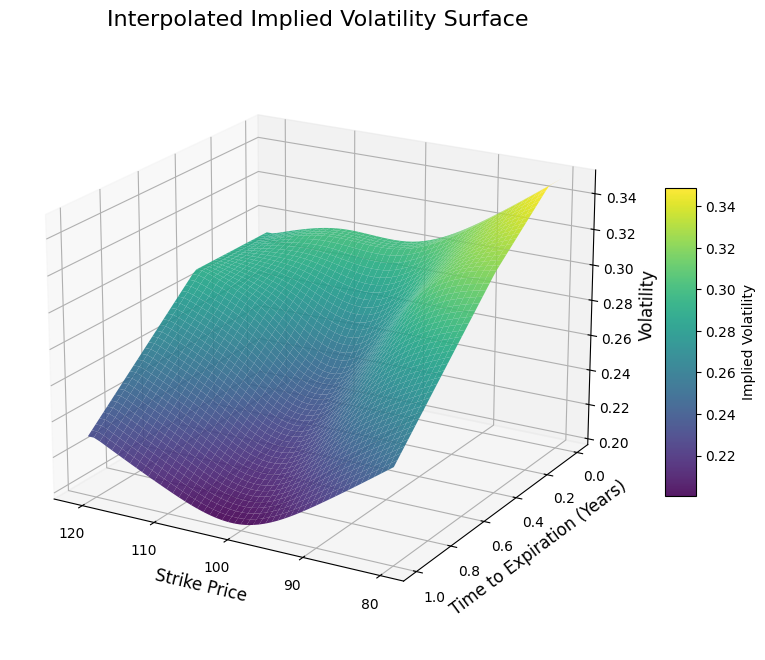

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

vol_spots = tf.convert_to_tensor([np.linspace(80, 121, 50).data], dtype)
vol_expiry_times = tf.convert_to_tensor([np.linspace(0, 1, 50).data], dtype)

X, Y = tf.meshgrid(vol_spots[0], vol_expiry_times[0])

interpolated_vols = tf.convert_to_tensor([vs.volatility(
                        strike=vol_spots,
                        expiry_times=vol_expiry_times[0, i]).numpy().tolist()[0] for i in range(0, 50)], dtype)

# Plot the surface
surf = ax.plot_surface(X.numpy(), Y.numpy(), interpolated_vols.numpy(), cmap='viridis', alpha=0.9)

# Set labels and title
ax.set_xlabel('Strike Price', fontsize=12)
ax.set_ylabel('Time to Expiration (Years)', fontsize=12)
ax.set_zlabel('Volatility', fontsize=12)
ax.set_title('Interpolated Implied Volatility Surface', fontsize=16)

# Add a color bar for the implied volatility
fig.colorbar(surf, shrink=0.5, aspect=10, label='Implied Volatility')

# You can rotate the view for better perspective
ax.view_init(elev=20, azim=120) # elev is elevation, azim is azimuthal angle

plt.show()

## Create Local Volatility Model

Now that we have a volatility surface object, we can create a `LocalVolatilityModel` instance through the method `from_volatility_surface` which build a `LocalVolatilityModel` from implied volatility data using the Dupire’s formula in terms of implied volatility.

In [ ]:
spot = 100 #@param { type: "number" }
dividend_yield = 0.0 #@param { type: "number" }

local_vol_model = lv.LocalVolatilityModel.from_volatility_surface(
          dim=dim,
          spot=spot,
          implied_volatility_surface=vs,
          discount_factor_fn=discount_factor_fn,
          dividend_yield=[dividend_yield],
          dtype=dtype)

The thing to pay attention to when solving the LocalModelVolatility PDE in `tff` is that the `drift_fn` and the `vol_fn` in the class are defined for $log\text{-spots}$, thus the `coord_grid` and the `final_value_grid` have to be adjsuted accordingly.

In [ ]:
#@markdown **PDE solver hyperameters**
strike = 100 #@param { type: "number" }
expiry = 1.0 #@param { type: "number" }
#@markdown Grid parameters
s_min = 0.01 #@param { type: "number" }
s_max = 200.01    #@param { type: "number" }
num_grid_points = 300 #@param { type: "number" }
pde_time_step = 0.1 #@param { type: "number" }

strike_t = tf.constant(strike, dtype)
expiry_t = tf.constant(expiry, dtype)

@tff.math.pde.boundary_conditions.dirichlet
def upper_boundary_fn(t, grid):
  del grid
  return tf.squeeze(s_max - strike_t * tf.exp(-r  * (expiry_t - t)))

def discounting(t, x):
  del t, x
  rates_expand = tf.expand_dims(r, axis=-1)
  return rates_expand


grid = tff.math.pde.grids.uniform_grid(
    minimums=[s_min],
    maximums=[s_max],
    sizes=[num_grid_points],
    dtype=dtype
)

log_grid = [tf.math.log(grid[0])]

# Shape [num_processes, num_strikes, num_grid_points]
final_value_grid = tf.nn.relu(tf.math.exp(log_grid[0]) - strike_t)

pde_res = local_vol_model.fd_solver_backward(
    start_time=expiry,
    end_time=0.0,
    time_step=pde_time_step,
    coord_grid=log_grid,
    values_grid=final_value_grid,
    disocunting=discounting,
    boundary_condtions=[(None, upper_boundary_fn)]
)[0]

In [ ]:
#@markdown **Insert the spot price:**
spot = 100 #@param { type: "number" }
print(f"The value of the option when the spot is {spot} is {pde_res[int(spot * num_grid_points / (s_max - s_min))].numpy():.2f}")

The value of the option when the spot is 100 is 8.91


# Heston Model

Another major class of models developed as an extension to the Black-Scholes framework is **stochastic volatility models**. These models aim to address a key limitation of Black-Scholes: the assumption that volatility is constant over time. In reality, market volatility is dynamic — it clusters, fluctuates, and responds to market events. Stochastic volatility models capture this behavior by treating volatility not as a fixed parameter, but as a random process governed by its own stochastic differential equation (SDE).

One of the most influential and widely used stochastic volatility models is the **Heston model**, introduced by Steven Heston in 1993. The Heston model assumes that the asset price and its variance evolve according to the following system of SDEs under the risk-neutral measure:

$$
\begin{aligned}
dS_t &= r S_t\,dt + \sqrt{v_t} S_t\,dW_t^S \\
dv_t &= \kappa(\theta - v_t)\,dt + \sigma \sqrt{v_t}\,dW_t^v
\end{aligned}
$$

where:

* $S_t$ is the asset price at time $t$,
* $v_t$ is the instantaneous variance at time $t$,
* $r$ is the risk-free rate,
* $\kappa$ is the rate at which the variance reverts to its long-term mean $\theta$,
* $\sigma$ is the volatility of variance (also called **vol of vol**),
* $W_t^S$ and $W_t^v$ are two Brownian motions with correlation $\rho \in [-1, 1]$.

This formulation allows volatility to evolve stochastically, mean-revert to a long-term level, and exhibit realistic features such as volatility clustering and leverage effects (through the correlation $\rho$).

### Heston PDE

The value $V(S, v, t)$ of a European-style option under the Heston model satisfies the following partial differential equation (PDE):

$$
\frac{\partial V}{\partial t} + r S \frac{\partial V}{\partial S} + \kappa(\theta - v)\frac{\partial V}{\partial v} + \frac{1}{2} v S^2 \frac{\partial^2 V}{\partial S^2} + \rho \sigma v S \frac{\partial^2 V}{\partial S \partial v} + \frac{1}{2} \sigma^2 v \frac{\partial^2 V}{\partial v^2} - r V = 0
$$

This PDE is two-dimensional, involving both the asset price $S$ and the variance $v$. Solving it requires more sophisticated numerical techniques than the standard Black-Scholes PDE, but it provides a significantly more accurate pricing framework, especially for options with longer maturities or far-from-the-money strikes.

In `tf_quant_finance` the `HestonModel` class is under `tff.models` module, and it is instantied in the following way:

In [ ]:
expiry_time = 1.0 #@param { type: "number" }
initial_spot = 100 #@param { type: "number" }
initial_vol = 0.05 #@param { type: "number" }
strike = 100 #@param { type: "number" }
discounting = 0.02 #@param { type: "number" }
#@markdown Heston parameters
mean_reversion = 0.3 #@param { type: "number" }
theta = 0.05 #@param { type: "number" }
volvol = 0.02 #@param { type: "number" }
rho = -0.7 #@param { type: "number" }

initial_log_spot = tf.math.log(tf.constant(initial_spot, dtype))
heston = HestonModel(
        mean_reversion=mean_reversion, theta=theta, volvol=volvol, rho=rho,
        dtype=dtype)

Since `HestonModel` is a child of `GenericItoProcess` class it inherits the `fd_solver_backward` method. Just keep in mind that the PDE is bidimensional, thus the grid has to be generated over the range of underlying prices (in our case log prices) and volatility values.

In [ ]:
log_s_min = 2 #@param { type: "number" }
log_s_max = 5 #@param { type: "number" }
v_min = 0.03 #@param { type: "number" }
v_max = 0.07 #@param { type: "number" }
grid_size_s = 156 #@param { type: "number" }
grid_size_v = 156 #@param { type: "number" }
time_step = 0.01 #@param { type: "number" }

grid = tff.math.pde.grids.uniform_grid(minimums=[log_s_min, v_min],
                              maximums=[log_s_max, v_max],
                              sizes=[grid_size_s, grid_size_v],
                              dtype=dtype)

s_mesh, _ = tf.meshgrid(grid[0], grid[1], indexing='ij')
final_value_grid = tf.nn.relu(tf.math.exp(s_mesh) - strike)
value_grid = heston.fd_solver_backward(
    start_time=1.0,
    end_time=0.0,
    coord_grid=grid,
    values_grid=final_value_grid,
    time_step=time_step,
    discounting=lambda *args: discounting)[0]

In [ ]:
#@markdown **Insert the spot price:**
spot = 100 #@param { type: "number" }
opt_price = value_grid[
    int(((log(spot) - log_s_min) * grid_size_s) / (log_s_max - log_s_min)),
    78
]
print(f"The value of the option when the spot is {spot} is {opt_price:.2f}")

The value of the option when the spot is 100 is 6.11
